In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [5]:
NUM_CLASSES = 4

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_split = 0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
21/23 [==========================>...] - ETA: 0s - loss: 1.3484 - accuracy: 0.3129
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
23/23 [==============================] - 1s 11ms/step - loss: 1.3479 - accuracy: 0.3095 - val_loss: 1.2443 - val_accuracy: 0.3983
Epoch 2/1000
20/23 [=========================>....] - ETA: 0s - loss: 1.2830 - accuracy: 0.3410
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
23/23 [==============================] - 0s 5ms/step - loss: 1.2794 - accuracy: 0.3444 - val_loss: 1.2112 - val_accuracy: 0.4387
Epoch 3/1000
19/23 [=======================>......] - ETA: 0s - loss: 1.2435 - accuracy: 0.3742
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
23/23 [==============================] - 0s 5ms/step - loss: 1.2415 - accuracy: 0.3729 - val_loss: 1.1775 - val_accuracy: 0.4276
Epoch 4/1000
20/23 [=========================>....] - ETA: 0s - loss: 1.2095 - accuracy: 0.3855


In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9465


In [15]:
model = tf.keras.models.load_model(model_save_path)

In [17]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 93ms/step
[9.74304974e-01 2.55991705e-02 8.40844223e-05 1.17843165e-05]
0


38/38 [==============================] - 0s 1ms/step


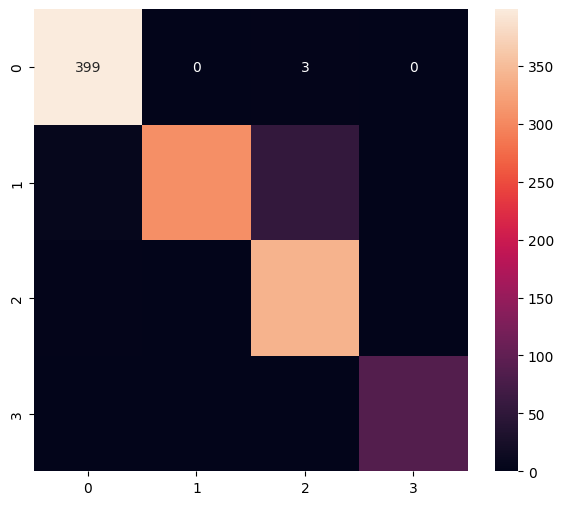

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       402
           1       1.00      0.84      0.91       366
           2       0.86      0.99      0.92       343
           3       1.00      1.00      1.00        86

    accuracy                           0.95      1197
   macro avg       0.96      0.96      0.96      1197
weighted avg       0.95      0.95      0.95      1197



In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [19]:
model.save(model_save_path, include_optimizer=False)

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpjp3jc6mp\assets


6544

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [22]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 5 ms


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0. 1. 0. 0.]
1
